In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import logging
from kafka import KafkaConsumer
from joblib import load
import numpy as np
import time
from pprint import pprint
import matplotlib.pyplot as plt

2024-04-27 14:30:48.210418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.get_logger().setLevel(logging.ERROR)

In [3]:
model_lstm = load_model('./models/kdd_model_lstm.keras')

In [4]:
model_gnb = load('./models/kdd_model_gnb.joblib')

In [5]:
model_rfc = load('./models/kdd_model_rfc.joblib')

In [6]:
class PredictionModel:
    def __init__(self, model):
        self.model = model
        
    def predict_LSTM(self, batch_data):
        prediction = self.model.predict(batch_data, verbose=0)
        return prediction
    
    def predict_ML_Methods(self, batch_data):
        prediction = self.model.predict(batch_data)
        return prediction

In [7]:
class RealTimePredictor:
    def __init__(self, model, topic, brokers, model_type):
        self.consumer = KafkaConsumer(
            topic,
            bootstrap_servers=brokers,
            auto_offset_reset='earliest', 
            value_deserializer=lambda x: x.decode('utf-8')  
        )
        self.model = model
        self.totalCount = 0
        self.maxCount = 98805
        self.model_type = model_type
        
    def consume_and_predict(self, kafka_batch_size):
        self.kafka_batch_size = kafka_batch_size
        if self.model_type == 'LSTM':
            self.consume_messages_lstm()
        elif self.model_type == 'ML_Methods':
            self.consume_messages_ML_Methods()
        
    def consume_messages_lstm(self):
        try:
            batch_data = []
            start_time = time.time()
            
            for message in self.consumer:
                data = message.value
                dataList = data.split(',')
                dataNumeric = np.array(dataList, dtype=float)
                features = dataNumeric[:-1]
                features = features.reshape((1, 40))
                self.totalCount += 1
                batch_data.append(features)
                
                if len(batch_data) == self.kafka_batch_size:
                    batch_data = np.array(batch_data)
                    predictions = self.model.predict_LSTM(batch_data)
                    batch_data = []
                
                if self.totalCount >= self.maxCount:
                    break
                
            if batch_data:
                batch_data = np.array(batch_data)
                predictions = self.model.predict_LSTM(batch_data)
                batch_data = []
            end_time = time.time()
            print('Processed {} test items'.format(self.totalCount))
        finally:
            self.consumer.close()

    def consume_messages_ML_Methods(self):
        try:
            batch_data = []
            start_time = time.time()
            
            for message in self.consumer:
                data = message.value
                dataList = data.split(',')
                dataNumeric = np.array(dataList, dtype=float)
                features = dataNumeric[:-1]
                self.totalCount += 1
                batch_data.append(features)
                
                if len(batch_data) == self.kafka_batch_size:
                    batch_data = np.array(batch_data)
                    predictions = self.model.predict_ML_Methods(batch_data)
                    batch_data = []
                
                if self.totalCount >= self.maxCount:
                    break
                
            if batch_data:
                batch_data = np.array(batch_data)
                predictions = self.model.predict_ML_Methods(batch_data)
                batch_data = []
            end_time = time.time()
            print('Processed {} test items'.format(self.totalCount))
        finally:
            self.consumer.close()

In [8]:
topic = "streamOut26A"
brokers = "localhost:9092"

lstm = PredictionModel(model_lstm)
gnb = PredictionModel(model_gnb)
rfc = PredictionModel(model_rfc)

In [9]:
kafka_batch_size_list = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]

In [10]:
prediction_model_item1 = {"model" : lstm, "name": "LSTM", "model_type" : "LSTM"}
prediction_model_item2 = {"model" : gnb, "name": "GNB", "model_type" : "ML_Methods"}
prediction_model_item3 = {"model" : rfc, "name": "RFC","model_type" : "ML_Methods"}
prediction_model_list = [prediction_model_item1, prediction_model_item2, prediction_model_item3] 

In [11]:
model_timings = {}
for item in prediction_model_list:
    
    item_model = item["model"]
    item_model_name = item["name"]
    item_model_type = item["model_type"] 
    
    model_timings[item_model_name] = []
    print("Processing {} ".format(item_model_name))
    
    for kafka_batch_size in kafka_batch_size_list:
        start_time = time.time()
        predictor = RealTimePredictor(item_model, topic, brokers, item_model_type)
        predictor.consume_and_predict(kafka_batch_size)
        end_time = time.time()
        model_timings[item_model_name].append(end_time - start_time)

pprint(model_timings)

Processing LSTM 
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processing GNB 
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processing RFC 
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
Processed 98805 test items
{'GNB': [2.4793701171875,
         2.4776740074157715,
         2.343717336654663,
         2.4665579795837402,
         2.5161449909210205,
         2.2806918621063232,
         2.578583002090454,
         2.4962191581726

In [12]:
def plot_model_performance(batch_sizes, model_timings):
    plt.figure(figsize=(10, 6))
    for model, values in model_timings.items():
        plt.plot(batch_sizes, values, marker='o', label=model)
    
    plt.xlabel('Kafka Batch Size')
    plt.ylabel('Time (seconds)')
    plt.title('Processing Time by Kafka Batch Size and Model')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.show()

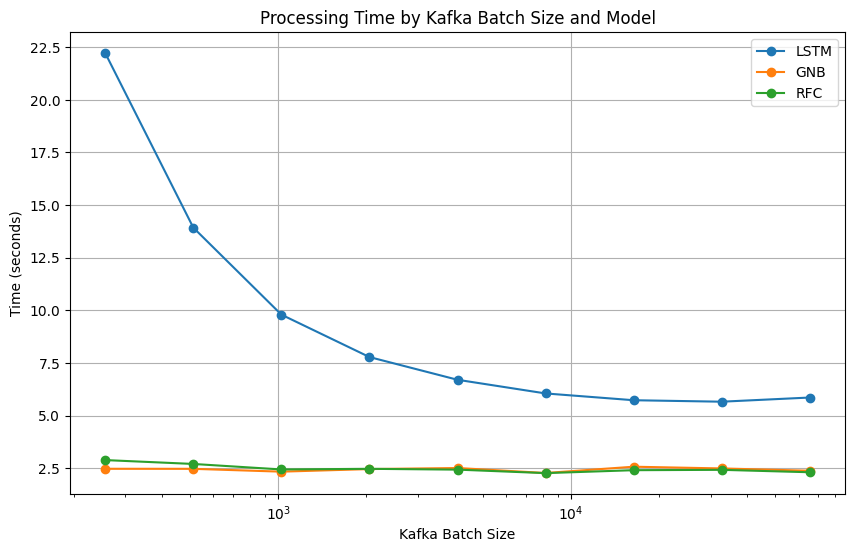

In [13]:
plot_model_performance(kafka_batch_size_list, model_timings)